# Plot Tree Edit Distance distribution
This notebook provides a Python function plot_ted_distribution_for_datasets to plot the **Tree Edit Distance (TED)** distribution for different datasets containing paraphrase data. It takes a list of pandas DataFrames, each representing a dataset, and plots histograms of **TED** scores for the top 3 paraphrases per unique input utterance.

The **TED** scores are computed using the *compute_tree_edit_distance* function from the *syn_utility* module. The function helps researchers and developers visualize the similarity between the original input utterance and its top paraphrase candidates, aiding in evaluating paraphrase generation models.

We rely of the Tree Edit distance defined by [Controllable Paraphrase Generation with a Syntactic Exemplar](https://github.com/mingdachen/syntactic-template-generation/tree/master). The closer the **TED** score is to zero, the more similar the two syntaxes templates are.

We will plot **TED** distribution for all Experimental conditions datset generated through crowdsourcing in [Jorge et al](https://link.springer.com/chapter/10.1007/978-3-031-07472-1_15).
1. **baseline**
2. **baseline-cw**
3. **baseline-outliers**
4. **patterns by example**
5. **taboo patterns**

### Function: plot_ted_distribution

**Description:**
The `plot_ted_distribution` function is designed to generate a histogram plot of the distribution of Tree Edit Distance (TED) scores for the top 3 paraphrases per unique 'INPUT:row_pk' in a given DataFrame. TED is a measure of similarity between two syntax trees, and in this context, it is used to evaluate how similar the syntax patterns of paraphrases are to the original input utterance.

**Parameters:**
- **df (pd.DataFrame):** The input DataFrame containing the paraphrase data. The DataFrame should have the following columns:
  - 'INPUT:row_pk': A unique identifier for each group of paraphrases related to a specific input utterance.
  - 'OUTPUT:worker_uuid': The worker UUID associated with the paraphrase.
  - 'INPUT:intent': The intent associated with the input utterance.
  - 'INPUT:input_utterance': The original input utterance.
  - 'paraphrase_value': The paraphrase generated for the input utterance.
  - 'paraphrase_pattern': The syntax pattern of the paraphrase.
  - 'bert_score': The BERT score representing the similarity between the paraphrase and the input utterance.
  - ... and many more that are not of interest in this context.

**Returns:**
None

**Function Workflow:**
1. Group the input DataFrame by the 'INPUT:row_pk' column to separate paraphrases related to different input utterances. In [Jorge et al](https://link.springer.com/chapter/10.1007/978-3-031-07472-1_15), crowd workers were asked to generate 3 paraphrases per `INPUT:input_utterance` resulting in more than 3 paraphrases due to multiple crowd workers' involvement.
   In our work, we employed GPT to generate 3 paraphrases per seed utterance. To facilitate a meaningful comparison between the two studies, we will extract the top 3 paraphrases for each seed utterance in Jorge et al.'s work.
3. For each unique 'INPUT:row_pk' group:
   a. Sort the paraphrases by 'bert_score' in descending order to select the top 3 paraphrases.
   b. Compute the TED scores between the syntax pattern of the original input utterance and the selected top 3 paraphrases.
   c. Store the computed TED scores in a list.
4. Plot the TED scores distribution using a histogram to visualize the similarity between paraphrases and the input utterances.

**Note:**
- Tree Edit Distance (TED) is a measure of how many edit operations (insertion, deletion, or substitution) are needed to transform one syntax tree into another. A lower TED score indicates higher similarity between syntax trees.
- The function requires the 'syn_utility' module, which contains the 'compute_tree_edit_distance' function used to calculate TED scores.

**Usage:**
To use this function, pass the DataFrame containing the paraphrase data as the 'df' argument. The function will then process the data, compute TED scores, and display a histogram plot of the TED scores distribution for the top 3 paraphrases per unique 'INPUT:row_pk'.

In [ ]:
import os
import pathlib
import json
import time
import math

# let's just make sure we are at the root
os.chdir(pathlib.Path().absolute().parent)
current_directory = os.getcwd()
new_directory = f"{current_directory}/Jorge_paper_replication"
os.chdir(new_directory)
print(f"Current working directory: {os.getcwd()}")

In [2]:
import random
import requests
from collections import Counter

import pandas as pd
import numpy as np
import stanza
import seaborn as sns
from tqdm import tqdm

from lib import metrics
from lib import utility as utlty
from lib import prompts_utility
from lib import gpt_utility

import matplotlib.pyplot as plt
from typing import List

In [3]:
# Import stanza model
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency', tokenize_no_ssplit=True)

2024-07-16 14:10:03 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-07-16 14:10:04 INFO: Loading these models for language: en (English):
| Processor    | Package  |
---------------------------
| tokenize     | combined |
| pos          | combined |
| constituency | wsj      |

2024-07-16 14:10:04 INFO: Use device: cpu
2024-07-16 14:10:04 INFO: Loading: tokenize
2024-07-16 14:10:04 INFO: Loading: pos
2024-07-16 14:10:05 INFO: Loading: constituency
2024-07-16 14:10:05 INFO: Done loading processors!


### Read the input

In [ ]:
input_file = f"{os.getcwd()}/input/Jorge-bootstrap-with-bertscores.csv"#test_data
df = pd.read_csv(input_file)

# Remove quotes from the 'INPUT:input_utterance' column (first and last occurrences)
# e.g. "Terminate i-a541 now" -> Terminate i-a541 now
df['INPUT:input_utterance'] = df['INPUT:input_utterance'].apply(lambda x: x[1:-1] if x.startswith('"') and x.endswith('"') else x)
df.head()[['INPUT:input_utterance','paraphrase_value','paraphrase_pattern']]

# test_df = df.head(2).copy()

,INPUT:input_utterance,paraphrase_value,paraphrase_pattern
0,Terminate i-a541 now,Finish i-a541 now.,( ROOT ( FRAG ( NP ) ( ADVP ) ) )
1,Terminate i-a541 now,Complete i-a541 now.,( ROOT ( FRAG ( NP ) ( ADVP ) ) )
2,Terminate i-a541 now,End i-a541 now.,( ROOT ( FRAG ( NP ) ( ADVP ) ) )
3,Terminate i-a541 now,Finish i-a541 now.,( ROOT ( FRAG ( NP ) ( ADVP ) ) )
4,Terminate i-a541 now,Quit i-a541 right away.,( ROOT ( S ( VP ) ) )


In [ ]:
df.shape

(1224, 44)

### Extract Syntax Template

#### Extract Syntax template for `INPUT:input_utterance`  columns

In [ ]:
def apply_and_append_paraphrase_pattern(df,selected_column,syntax_column_name):
    """
    Extract the syntax pattern from the selected column of the DataFrame and append it as a new column.

    :args
        df (pd.DataFrame): The DataFrame containing the selected column with paraphrases. 
        selected_column (str): The name of the column to extract the syntax pattern from.
        syntax_column_name (str): he name of the new column that will store the extracted syntax pattern.

    :return
        None The DataFrame 'df' is modified in-place with the new column 'syntax_column_name'.
    """

    # Define a function to apply 'extract_syntax_pattern' on the 'selected_column' column
    def extract_syntax_for_paraphrase(paraphrase):
        syntax_pattern, _, _ = utlty.extract_syntax_pattern(nlp, paraphrase)
        return syntax_pattern

    # Apply the 'extract_syntax_for_paraphrase' function on the 'selected_column' column and append the result as a new column
    tqdm.pandas(desc=f"Processing {syntax_column_name}")
    df[syntax_column_name] = df[selected_column].progress_apply(extract_syntax_for_paraphrase)

#### Remove unnecessary columns from the DataFrame.

In [14]:
df.columns

Index(['INPUT:row_pk', 'OUTPUT:worker_uuid', 'INPUT:intent',
       'INPUT:input_utterance', 'paraphrase_value', 'rand_baseline', 'rand_cw',
       'distance_to_mean', 'distance_to_seed', 'INPUT:parameters',
       'is_correct', 'tag', 'C2.is_correct_m', 'C2.tag_m', 'C1.C2.agreement',
       'paraphrase_pattern', 'INPUT:prompt_context', 'paraphrase_key',
       'INPUT:source', 'INPUT:input_pattern', 'INPUT:masked_ngrams',
       'INPUT:input_utterance_words', 'INPUT:input_utterance_lemmatized_words',
       'OUTPUT:trace', 'OUTPUT:screen_width', 'OUTPUT:screen_height',
       'OUTPUT:page_started_at', 'OUTPUT:provided_ngrams',
       'OUTPUT:page_started_at_string', 'ASSIGNMENT:link',
       'ASSIGNMENT:task_id', 'ASSIGNMENT:assignment_id',
       'ASSIGNMENT:task_suite_id', 'ASSIGNMENT:worker_id', 'ASSIGNMENT:status',
       'ASSIGNMENT:started', 'ASSIGNMENT:submitted', 'ASSIGNMENT:accepted',
       'ASSIGNMENT:rejected', 'ASSIGNMENT:skipped', 'ASSIGNMENT:expired',
       'ASSIGNMENT:

In [15]:
# 'INPUT:parameters','INPUT:source' 'paraphrase_value'
# List of columns to drop
columns_to_drop = [
    'rand_baseline', 'paraphrase_pattern','rand_cw',
    'distance_to_mean','distance_to_seed',
    'INPUT:prompt_context', 'paraphrase_key', 'INPUT:input_pattern',
    'INPUT:masked_ngrams', 'INPUT:input_utterance_words','INPUT:input_utterance_lemmatized_words',
    'OUTPUT:trace','OUTPUT:screen_width','OUTPUT:screen_height','OUTPUT:page_started_at','OUTPUT:provided_ngrams','OUTPUT:page_started_at_string',
    'ASSIGNMENT:link','ASSIGNMENT:task_id',
    'ASSIGNMENT:assignment_id','ASSIGNMENT:task_suite_id','ASSIGNMENT:worker_id','ASSIGNMENT:status','ASSIGNMENT:started',
    'ASSIGNMENT:submitted','ASSIGNMENT:accepted','ASSIGNMENT:rejected','ASSIGNMENT:skipped','ASSIGNMENT:expired','ASSIGNMENT:reward',
    'judgment_time','OUTPUT:worker_uuid','tag', 'C2.is_correct_m', 'C2.tag_m', 'C1.C2.agreement'
]

# Drop the columns from the DataFrame
df.drop(columns=columns_to_drop, inplace=True)
df.columns

Index(['INPUT:row_pk', 'INPUT:intent', 'INPUT:input_utterance',
       'paraphrase_value', 'INPUT:parameters', 'is_correct', 'INPUT:source',
       'bert_score'],
      dtype='object')

##### Update the names of the remaining columns for better clarity.

In [16]:
df.rename(columns={
    'INPUT:row_pk': 'seed_id',
    'INPUT:intent': 'intent',
    'INPUT:input_utterance': 'input_utterance',
    'INPUT:parameters': 'parameters',
    'INPUT:source': 'source'
}, inplace=True)

<div style="background-color: #d4edda; color: #155724; padding: 10px; border: 1px solid #c3e6cb;">
    <strong>Warning:</strong> The execution of the next cell may take a long time to finish. Please be patient.
    <div>1. Extract syntax templates for input_utterance.</div>
    <div>2. Extract syntax templates for paraphrase_value.</div>
</div>

In [17]:
apply_and_append_paraphrase_pattern(df,'input_utterance','utterance_template')

apply_and_append_paraphrase_pattern(df,'paraphrase_value','paraphrase_template')
df.head()[['input_utterance','utterance_template','paraphrase_template']]

Processing paraphrase_template: 100%|██████████| 1224/1224 [01:20<00:00, 15.27it/s]


,input_utterance,utterance_template,paraphrase_template
0,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ( . ) )
1,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( FRAG ( NP ( JJ ) ( NN ) ) ( ADVP ( RB ) ) ( ...
2,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( NN ) ( NP ) ( ADVP ) ) ( . ) )
3,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ( . ) )
4,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ( . ) )


#### Compute the Tree Edit Distance (TED) between `input_utterance` and `paraphrase_value`

In [18]:
tqdm.pandas(desc=f"Compute TED")
df['ted'] = df.progress_apply(lambda row: utlty.syn_utility.compute_tree_edit_distance(row['utterance_template'], row['paraphrase_template']), axis=1)
df.head()[['input_utterance','utterance_template','paraphrase_template','ted','bert_score']]

Compute TED: 100%|██████████| 1224/1224 [00:00<00:00, 1292.65it/s]


,input_utterance,utterance_template,paraphrase_template,ted,bert_score
0,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ( . ) ),1.0,0.399534
1,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( FRAG ( NP ( JJ ) ( NN ) ) ( ADVP ( RB ) ) ( ...,6.0,0.387085
2,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( NN ) ( NP ) ( ADVP ) ) ( . ) ),2.0,0.398089
3,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ( . ) ),1.0,0.399534
4,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ( . ) ),1.0,0.302160


### Compute Bertscore

In [19]:
from bert_score import score
from transformers import logging

logging.set_verbosity_error()#suppressing the display of warning messages.

def calculate_bert_scores(df,templates = ['p1', 'p2', 'p3']):
    """
    Calculate BERTScores for each pair of 'input_utterance' and paraphrases'pX' columns,
    and store the scores in the new columns 'pX_bertscore'.

    :args
        df(pd.DataFrame): The DataFrame containing the 'input_utterance' and 'pX_template' columns.
    """
    
    for template in tqdm(templates):
        col_bertscore = f'{template}_bertscore'
        _, _, bert_scores = score(list(df['INPUT:input_utterance']), list(df[template]), lang="en")
        df[col_bertscore] = bert_scores

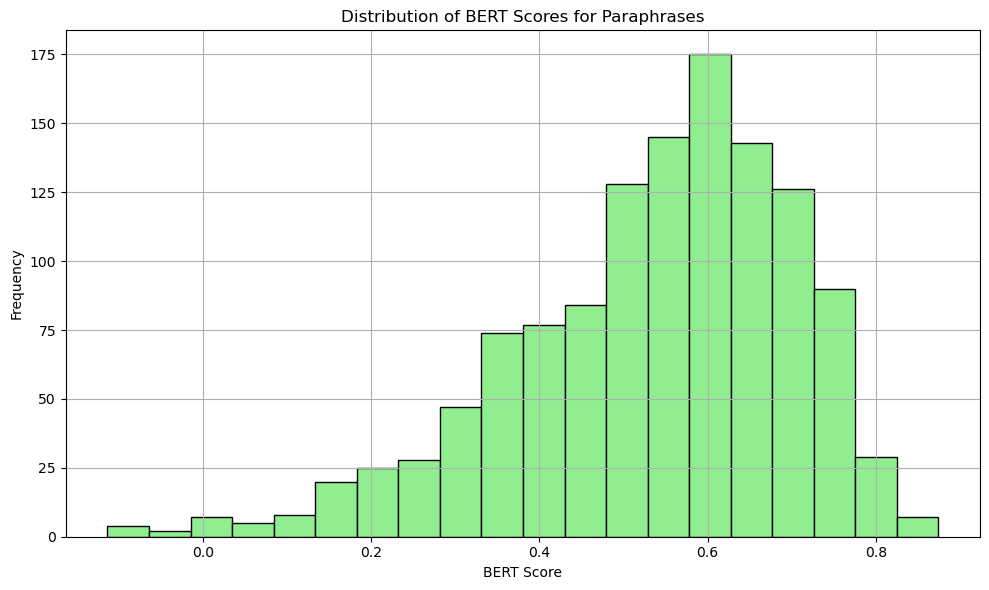

In [20]:
# Create a figure with subplots
plt.figure(figsize=(10, 6))
plt.hist(df['bert_score'], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('BERT Score')
plt.ylabel('Frequency')
plt.title('Distribution of BERT Scores for Paraphrases')
plt.grid(True)
plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/plots/Jorge_bootstrap_BERT_distribution_all.pdf"#test_data
plt.savefig(path_to_plot_file)

plt.show()

## Sanity Check
We perform two checks on the generated paraphrases to ensure they are not duplicates or semantically unrelated. The bertscore metric is used for this purpose.
1. If the bertscore is greater than 0.98, the current paraphrase is identified as a duplicate.
2. If the bertscore is less than 0.5, the current paraphrase is considered not semantically related to the input_utterance.

In [21]:
df['duplicate'] = df['bert_score'] > 0.98
df['semantics'] = (df['bert_score'] >= 0.5) & (df['bert_score'] <= 0.98)
df.head()[["seed_id","input_utterance","paraphrase_value", "bert_score","semantics","duplicate"]]

,seed_id,input_utterance,paraphrase_value,bert_score,semantics,duplicate
0,1,Terminate i-a541 now,Finish i-a541 now.,0.399534,False,False
1,1,Terminate i-a541 now,Complete i-a541 now.,0.387085,False,False
2,1,Terminate i-a541 now,End i-a541 now.,0.398089,False,False
3,1,Terminate i-a541 now,Finish i-a541 now.,0.399534,False,False
4,1,Terminate i-a541 now,Quit i-a541 right away.,0.302160,False,False


#### Statistics
This cell helps in identifying rows that are duplicates or not semantically related in a given DataFrame.

In [22]:
# Print rows that are duplicates
print(f"Count of paraphrases that are duplicates:: {df[df['duplicate']].shape[0]}")

# Print rows that are not semantically related
print(f"Count of paraphrases that are not semantically related: {df[~df['semantics']].shape[0]}")

Count of paraphrases that are duplicates:: 0
Count of paraphrases that are not semantically related: 434


## Plot
This code generates figures containing three subplots, each illustrating the distribution of **TED** scores, **BERT scores**, and **syntax templates**. Will sequentially plot all paraphrases and correct paraphrases.

#### <div style="background-color: lightblue; padding: 10px;">Visualize the Distribution of TED Scores for the Paraphrases</div>

##### <div style="background-color: lightblue; padding: 10px;">Visualize the Distribution of TED Scores for all Paraphrases</div>

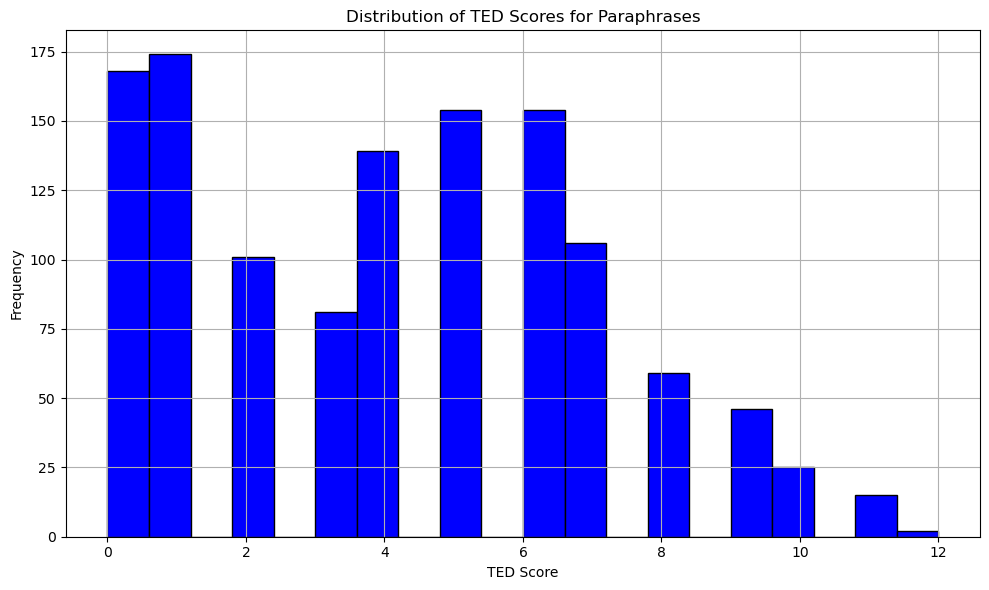

In [23]:
# Create a figure with subplots
plt.figure(figsize=(10, 6))
plt.hist(df['ted'], bins=20, color='blue', edgecolor='black')
plt.xlabel('TED Score')
plt.ylabel('Frequency')
plt.title('Distribution of TED Scores for Paraphrases')
plt.grid(True)
plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/plots/Jorge_bootstrap_TED_distribution_all.pdf"#test_data
plt.savefig(path_to_plot_file)

plt.show()

##### <div style="background-color: lightblue; padding: 10px;">Visualize the Distribution of TED Scores for correct Paraphrases only</div>

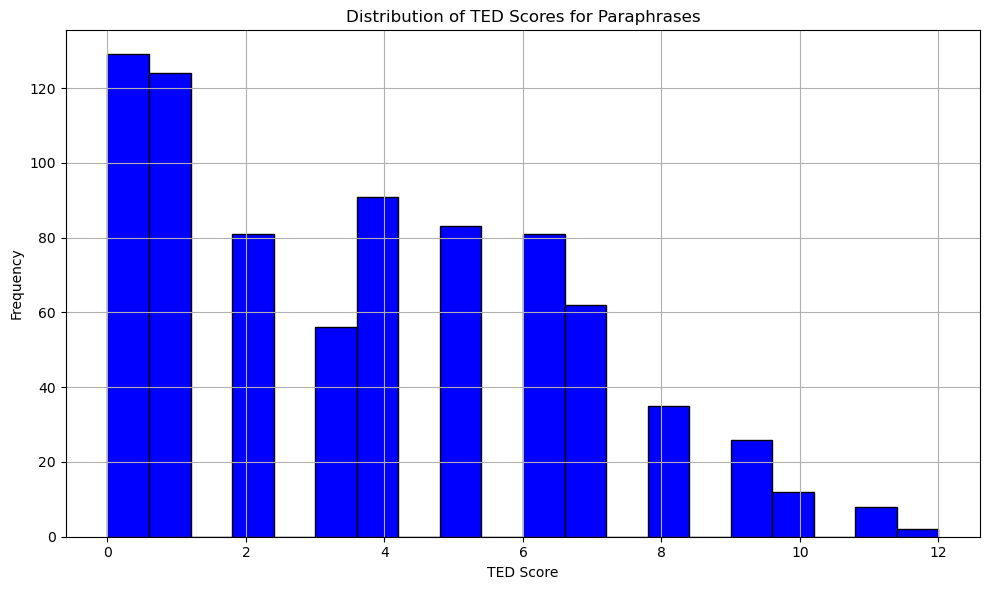

In [24]:
# Filter the DataFrame to get only correct paraphrases based on BERT_score
filtered_df = df[(df['duplicate'] == False) & (df['semantics'] == True)]

# Create a figure with subplots
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['ted'], bins=20, color='blue', edgecolor='black')
plt.xlabel('TED Score')
plt.ylabel('Frequency')
plt.title('Distribution of TED Scores for Paraphrases')
plt.grid(True)
plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/Jorge_bootstrap_TED_distribution_correct_only.pdf"#test_data
plt.savefig(path_to_plot_file)

plt.show()

##### Save the df

In [25]:
output_file = f"{os.getcwd()}/output/Jorge_bootstrap_correct_only.csv"
filtered_df.to_csv(output_file, index=False)
print(f"Shape of correct: {filtered_df.shape}")

filtered_df = df[(df['semantics'] == False)]
output_file = f"{os.getcwd()}/output/Jorge_bootstrap_incorrect.csv"
filtered_df.to_csv(output_file, index=False)
print(f"Shape of correct: {filtered_df.shape}")

Shape of correct: (790, 13)
Shape of correct: (434, 13)


#### <div style="background-color: lightgreen; padding: 10px;">Visualize the Distribution of BERT Scores for the Paraphrases</div>

##### <div style="background-color: lightgreen; padding: 10px;">Visualize the Distribution of BERT Scores for all Paraphrases</div>

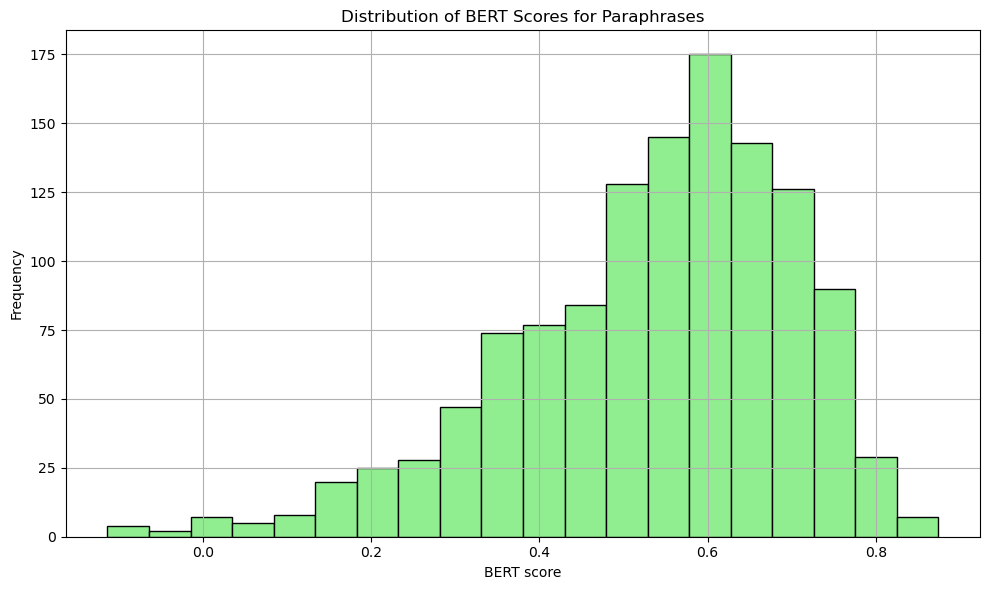

In [26]:
# Create a figure with subplots
plt.figure(figsize=(10, 6))
plt.hist(df['bert_score'], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('BERT score')
plt.ylabel('Frequency')
plt.title('Distribution of BERT Scores for Paraphrases')
plt.grid(True)
plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/plots/Jorge_bootstrap_BERTscores_distribution_all.pdf"#test_data
plt.savefig(path_to_plot_file)

plt.show()

##### <div style="background-color: lightgreen; padding: 10px;">Visualize the Distribution of BERT Scores for correct Paraphrases only</div>

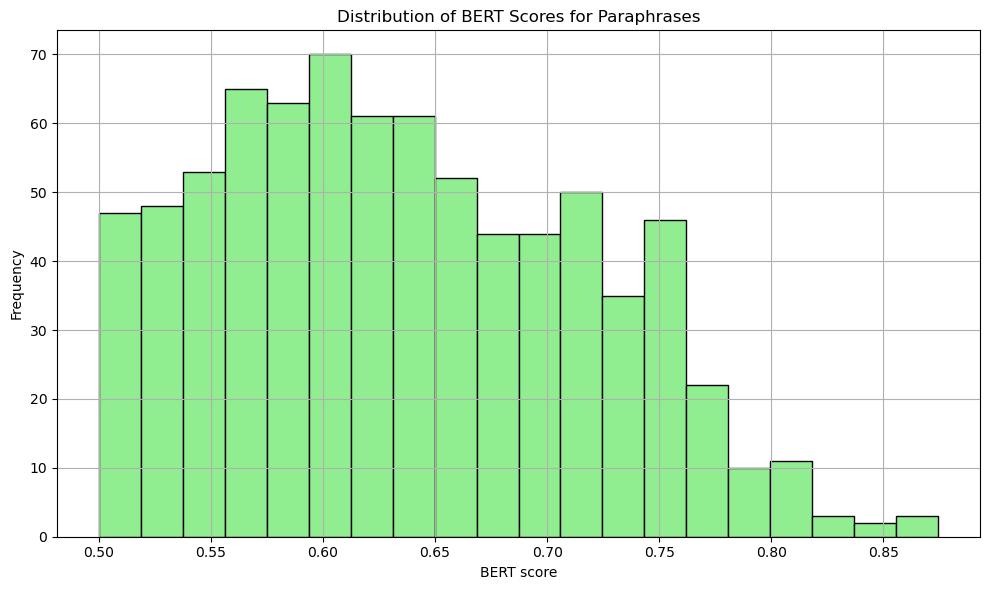

In [27]:
# Filter the DataFrame to get only correct paraphrases based on BERT_score
filtered_df = df[(df['duplicate'] == False) & (df['semantics'] == True)]

# Create a figure with subplots
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['bert_score'], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('BERT score')
plt.ylabel('Frequency')
plt.title('Distribution of BERT Scores for Paraphrases')
plt.grid(True)
plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/Jorge_bootstrap_BERT_distribution_correct_only.pdf"#test_data
plt.savefig(path_to_plot_file)

plt.show()

#### <div style="background-color: lightblue; padding: 10px;">Visualize the Distribution of Syntax tenplates for correct Paraphrases only</div>

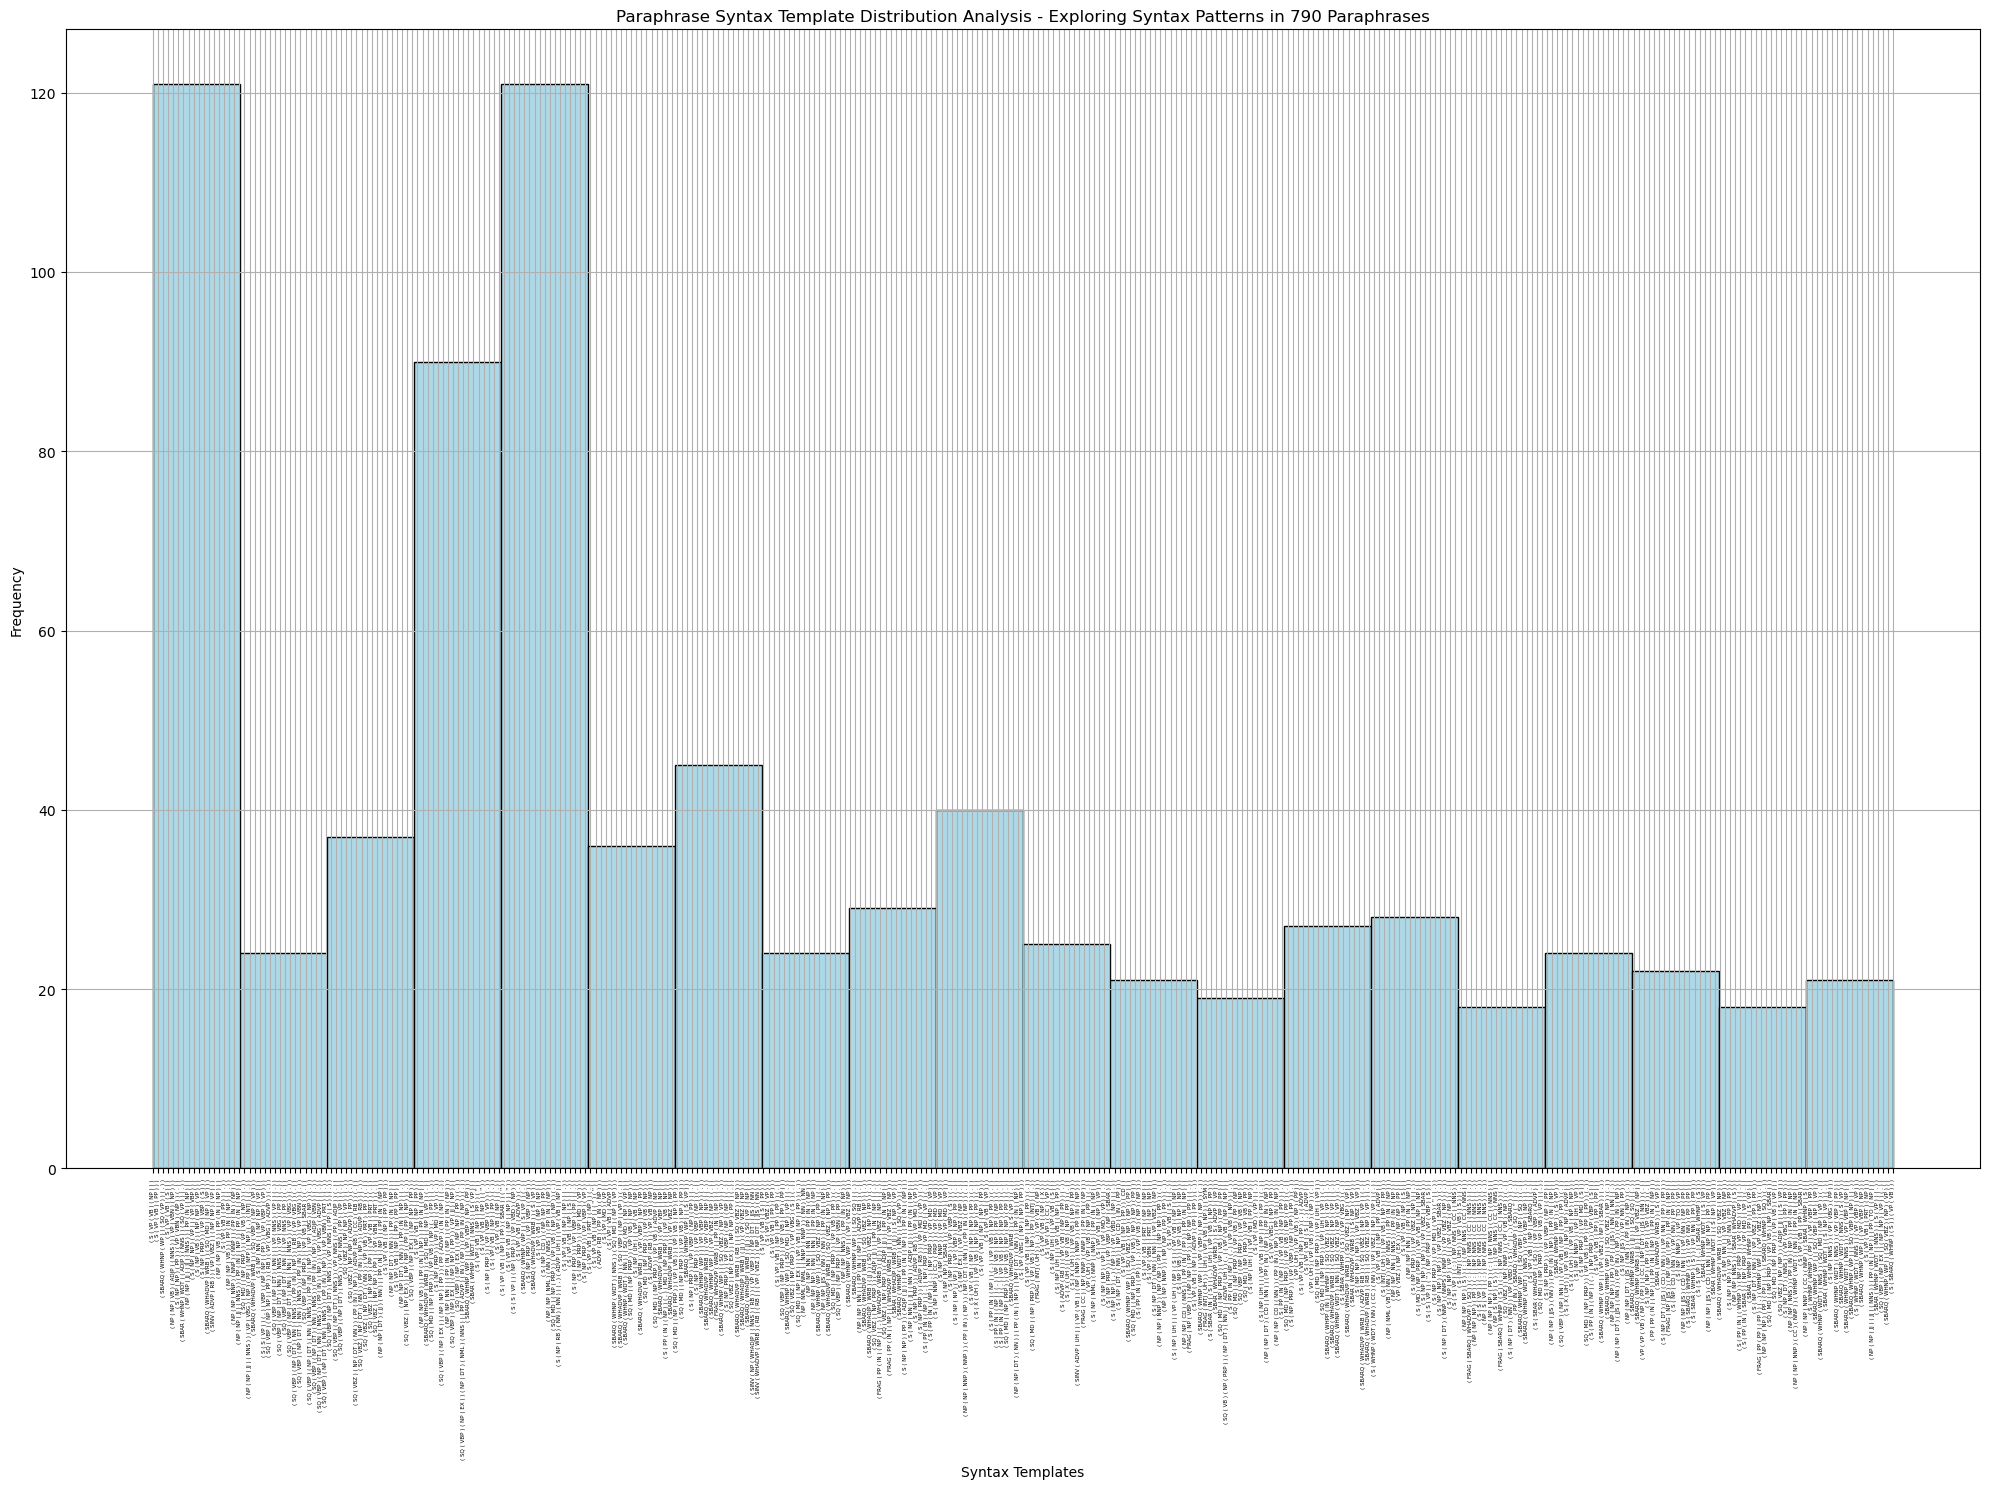

In [28]:
# Create a figure with subplots
number_of_rows = filtered_df.shape[0]
title= f"Paraphrase Syntax Template Distribution Analysis - Exploring Syntax Patterns in {number_of_rows} Paraphrases"
plt.figure(figsize=(20, 15))
plt.hist(filtered_df['paraphrase_template'], bins=20, color='lightblue', edgecolor='black')
plt.xlabel('Syntax Templates')
plt.ylabel('Frequency')
plt.title(title)
plt.xticks(rotation='vertical', fontsize=4)
plt.grid(True)
plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/plots/Jorge_bootstrap_paraphrase_template_distribution_correct_only.pdf"#test_data
plt.savefig(path_to_plot_file)

plt.show()

#### <div style="background-color: lightblue; padding: 10px;">Visualize the Distribution of Syntax tenplates for all Paraphrases</div>

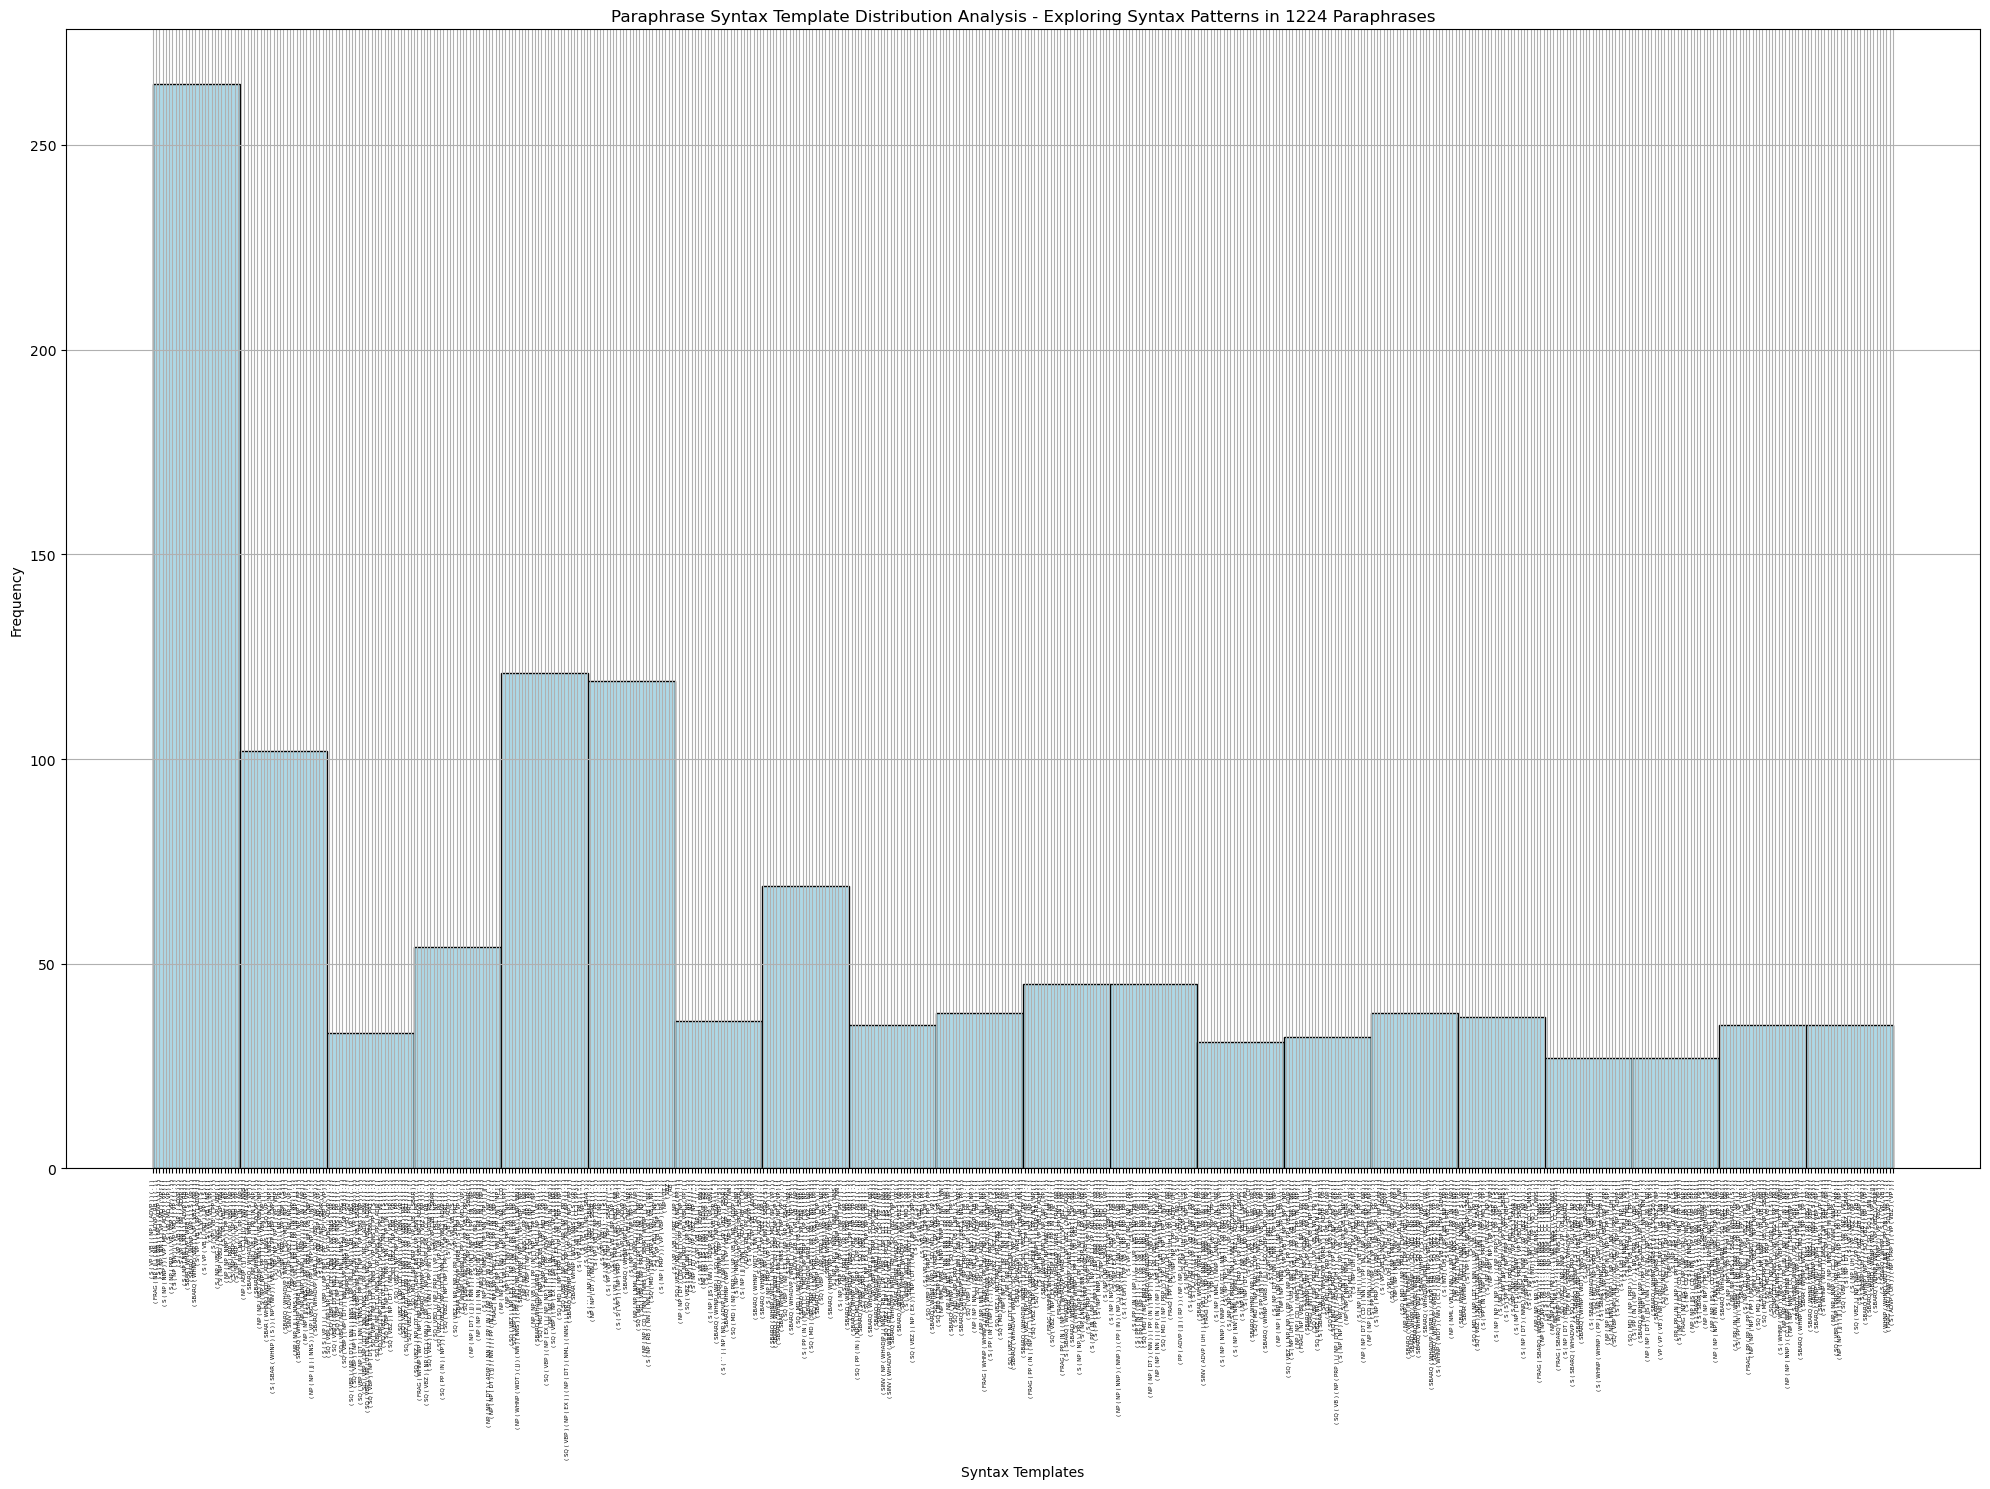

In [29]:
# Create a figure with subplots
number_of_rows = df.shape[0]
title= f"Paraphrase Syntax Template Distribution Analysis - Exploring Syntax Patterns in {number_of_rows} Paraphrases"
plt.figure(figsize=(20, 15))
plt.hist(df['paraphrase_template'], bins=20, color='lightblue', edgecolor='black')
plt.xlabel('Syntax Templates')
plt.ylabel('Frequency')
plt.title(title)

plt.xticks(rotation='vertical', fontsize=4)
plt.grid(True)
plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/plots/Jorge_bootstrap_paraphrase_template_distribution_all.pdf"#test_data
plt.savefig(path_to_plot_file)

plt.show()

In [31]:
print("Correct paraphrases only")
p1_bertscore_median = filtered_df["bert_score"].median()
p1_bertscore_mean = filtered_df["bert_score"].mean()
print(f"p1_bertscore_mean: Median: {p1_bertscore_median:.4f}. Mean: {p1_bertscore_mean:.4f}.\n")

print()
print("All paraphrases")
p1_bertscore_median = df["bert_score"].median()
p1_bertscore_mean = df["bert_score"].mean()
print(f"p1_bertscore_mean: Median: {p1_bertscore_median:.4f}. Mean: {p1_bertscore_mean:.4f}.\n")

Correct paraphrases only
p1_bertscore_mean: Median: 0.6271. Mean: 0.6356.


All paraphrases
p1_bertscore_mean: Median: 0.5630. Mean: 0.5355.



In [32]:
print(filtered_df.shape)
filtered_df.paraphrase_template.unique().shape

(790, 13)


(343,)

### Compute metrics
To analyze the quality of paraphrases, we will calculate three metrics: DIv, TTR, and mean PINC scores.

In [33]:
def compute_metrics(df, input_utterance):
    df_s = df[df["input_utterance"] == input_utterance]
    paraphrases = df_s["paraphrase_value"].values
    ttr_metric = metrics.compute_ttr(input_utterance, paraphrases)
    pincs = [metrics.compute_pinc(input_utterance, p) for p in paraphrases]
    mean_pinc = sum(pincs) / len(pincs)
    div = metrics.compute_div({input_utterance: paraphrases})
    return ttr_metric["ttr"], mean_pinc, div

def compute_metrics_for_df(df):
    ttrs = []
    mean_pincs = []
    divs = []

    for iu in df["input_utterance"].unique():
        ttr, mean_pinc, div = compute_metrics(df, iu)  # Assuming you have a function 'compute_metrics' that takes df and iu as arguments
        ttrs.append(ttr)
        mean_pincs.append(mean_pinc)
        divs.append(div)

    ttrs = np.array(ttrs)
    mean_pincs = np.array(mean_pincs)
    divs = np.array(divs)
    return ttrs, mean_pincs, divs

In [34]:
print("Compute TTR, PINC and DIV for correct paraphrases only:")
ttrs, mean_pincs, divs = compute_metrics_for_df(filtered_df)
print(f"   Mean TTR: {ttrs.mean():.4f} \n   Mean PINC: {mean_pincs.mean():.4f} \n   DIV: {divs.mean():.4f}")

print()
print("Compute TTR, PINC and DIV for all paraphrases:")
ttrs, mean_pincs, divs = compute_metrics_for_df(df)
print(f"   Mean TTR: {ttrs.mean():.4f} \n   Mean PINC: {mean_pincs.mean():.4f} \n   DIV: {divs.mean():.4f}")

Compute TTR, PINC and DIV for correct paraphrases only:
   Mean TTR: 0.1968 
   Mean PINC: 0.2154 
   DIV: 0.5983

Compute TTR, PINC and DIV for all paraphrases:
   Mean TTR: 0.1936 
   Mean PINC: 0.2662 
   DIV: 0.6809


# Pattern Distribution Plot
Analyzing Patterns in Correct Paraphrases for 50 Seed Utterances. The plot showcases the frequency distribution of paraphrase patterns, specifically focusing on the correct paraphrases. After selecting the correct paraphrases, 50 Seed Utterances remain for analysis.

In [35]:
def plot_and_save_pattern_distribution(df, output_path, width=16, height=10, min_ncols=8, iu_column="input_utterance"):
    ncols = min(min_ncols, df[iu_column].value_counts().shape[0])
    nrows = math.ceil(df[iu_column].value_counts().shape[0] / ncols)
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_figwidth(width)
    fig.set_figheight(height)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.suptitle("Overall Pattern Distribution", fontsize=16)
    
    row = 0
    col = 0

    # Define a color palette for the patterns
    pattern_colors = sns.color_palette("Set1", n_colors=3)
    
    for _, input_utterance in enumerate(df[iu_column].value_counts().index.values):
        df_data = df[df[iu_column] == input_utterance]
        ax = axes[row][col] if nrows > 1 else axes[col]
        g = sns.countplot(
            x="paraphrase_template",
            data=df_data,
            order=df_data.paraphrase_template.value_counts().sort_values().index,
            ax=ax,
            palette=pattern_colors
        )
        g.set(xlabel="patterns")
        g.set(xticklabels=[])
        col += 1
        
        if col == ncols:
            col = 0
            row += 1
    
    if output_path:
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

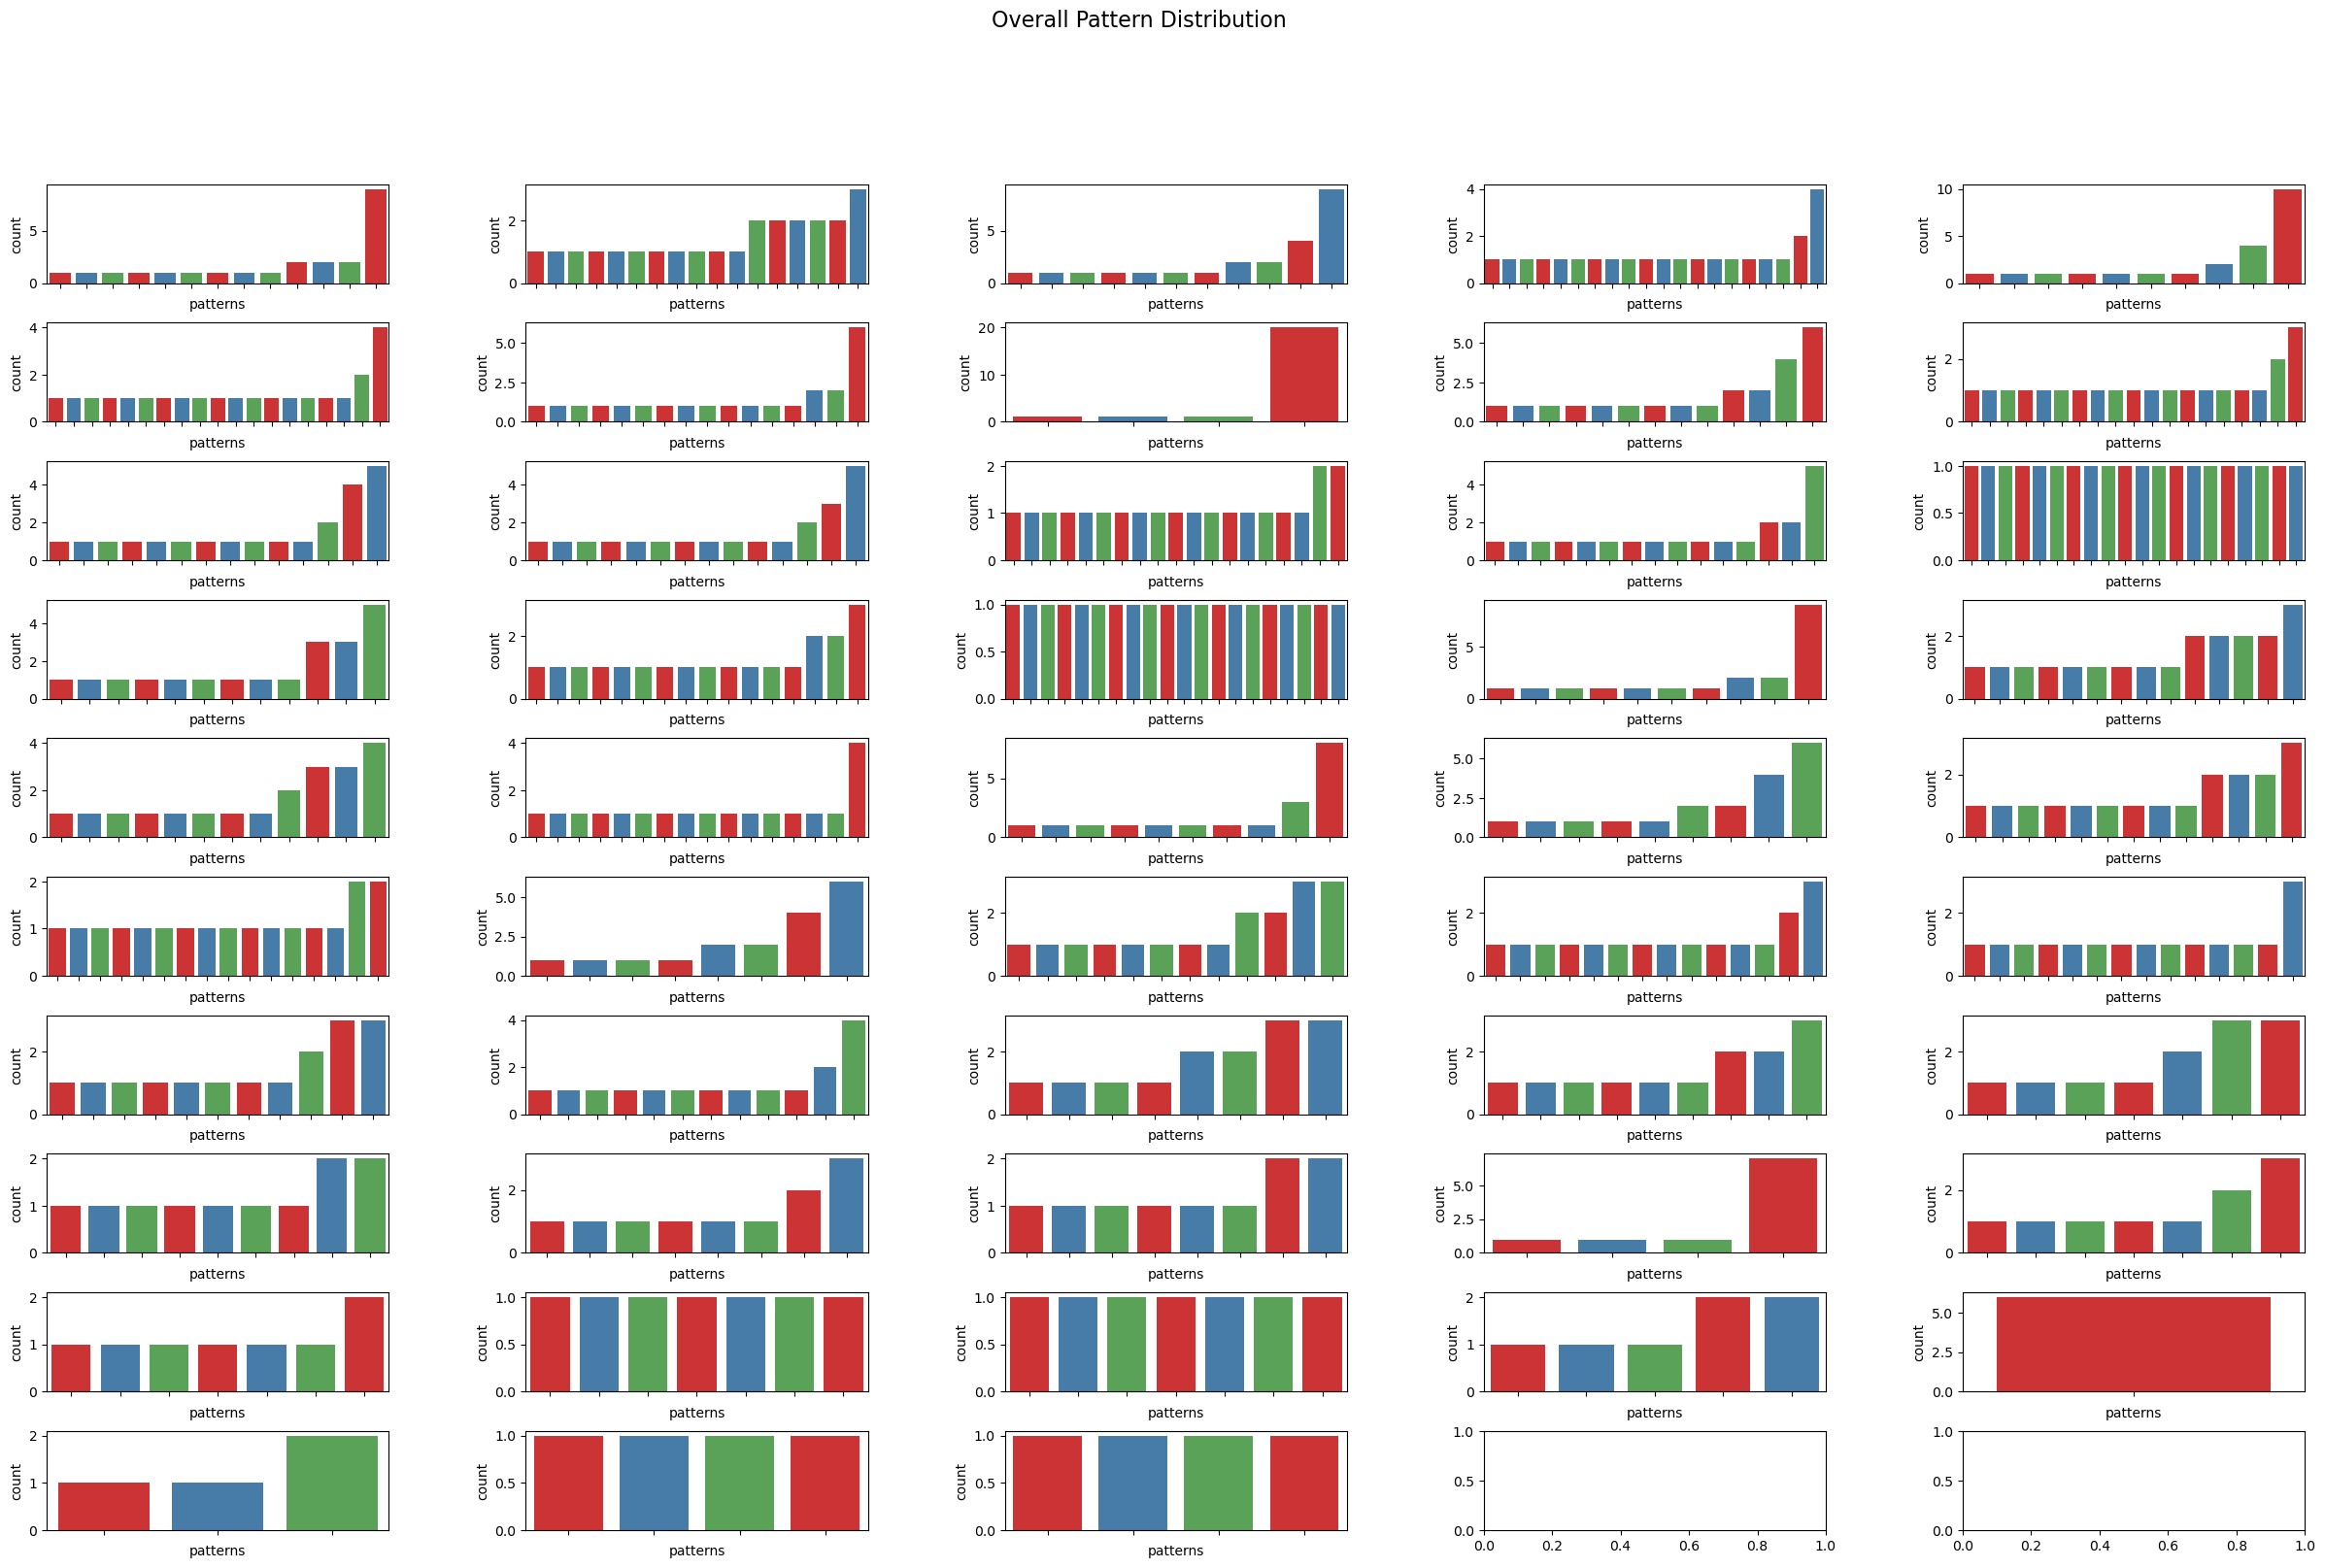

In [36]:
output_path = f"{os.getcwd()}/plots/Jorge-bootstrap-pattern-distribution-correct.pdf"
plot_and_save_pattern_distribution(filtered_df, output_path, width=30, height=18, min_ncols=5)

In [37]:
filtered_df.paraphrase_template.unique().shape

(343,)

### random selection and comparison of Syn templates

In [32]:
def plot_and_save_pattern_distribution(df, output_path, width=16, height=10, min_ncols=8, iu_column="input_utterance"):

    random_selected_syn = [
        'Search for cooking videos',
        'What is the forecast for Harrison-Crawford State Forest',
        'Are there any cheap hotels for 7-day stay somewhere near Riverside',
        'Search for a few nice photos matching Opera House with size 1024px * 768px',
        "I want reviews for McDonald's at Kensington st.",
        'Rate this album two out of 6',
        'what is the lowest fare from denver to pittsburgh',
        'Book a table for eight people please',
        'Is the TV in the house off ?',
        'please give me the cheapest flight from denver to pittsburgh'
    ]
    
    ncols = min(min_ncols, df[iu_column].value_counts().shape[0])
    nrows = math.ceil(df[iu_column].value_counts().shape[0] / ncols)
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_figwidth(width)
    fig.set_figheight(height)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.suptitle("Overall Pattern Distribution", fontsize=16)
    
    row = 0
    col = 0

    # Define a color palette for the patterns
    pattern_colors = sns.color_palette("Set1", n_colors=3)
    
    for _, input_utterance in enumerate(df[iu_column].value_counts().index.values):
        if input_utterance in random_selected_syn:
            df_data = df[df[iu_column] == input_utterance]
            ax = axes[row][col] if nrows > 1 else axes[col]
            g = sns.countplot(
                x="paraphrase_template",
                data=df_data,
                order=df_data.paraphrase_template.value_counts().sort_values().index,
                ax=ax,
                palette=pattern_colors
            )
            g.set(xlabel="patterns")
            ax.set(xlabel=None)
            g.set(xticklabels=[])
            g.set_title(f"{input_utterance}",fontdict= { 'fontsize': 8, 'fontweight':'bold'}, y =1.1)
            col += 1
            
            if col == ncols:
                col = 0
                row += 1
    
    if output_path:
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.subplots_adjust(hspace = 0.6)
    plt.show()
    plt.close(fig)

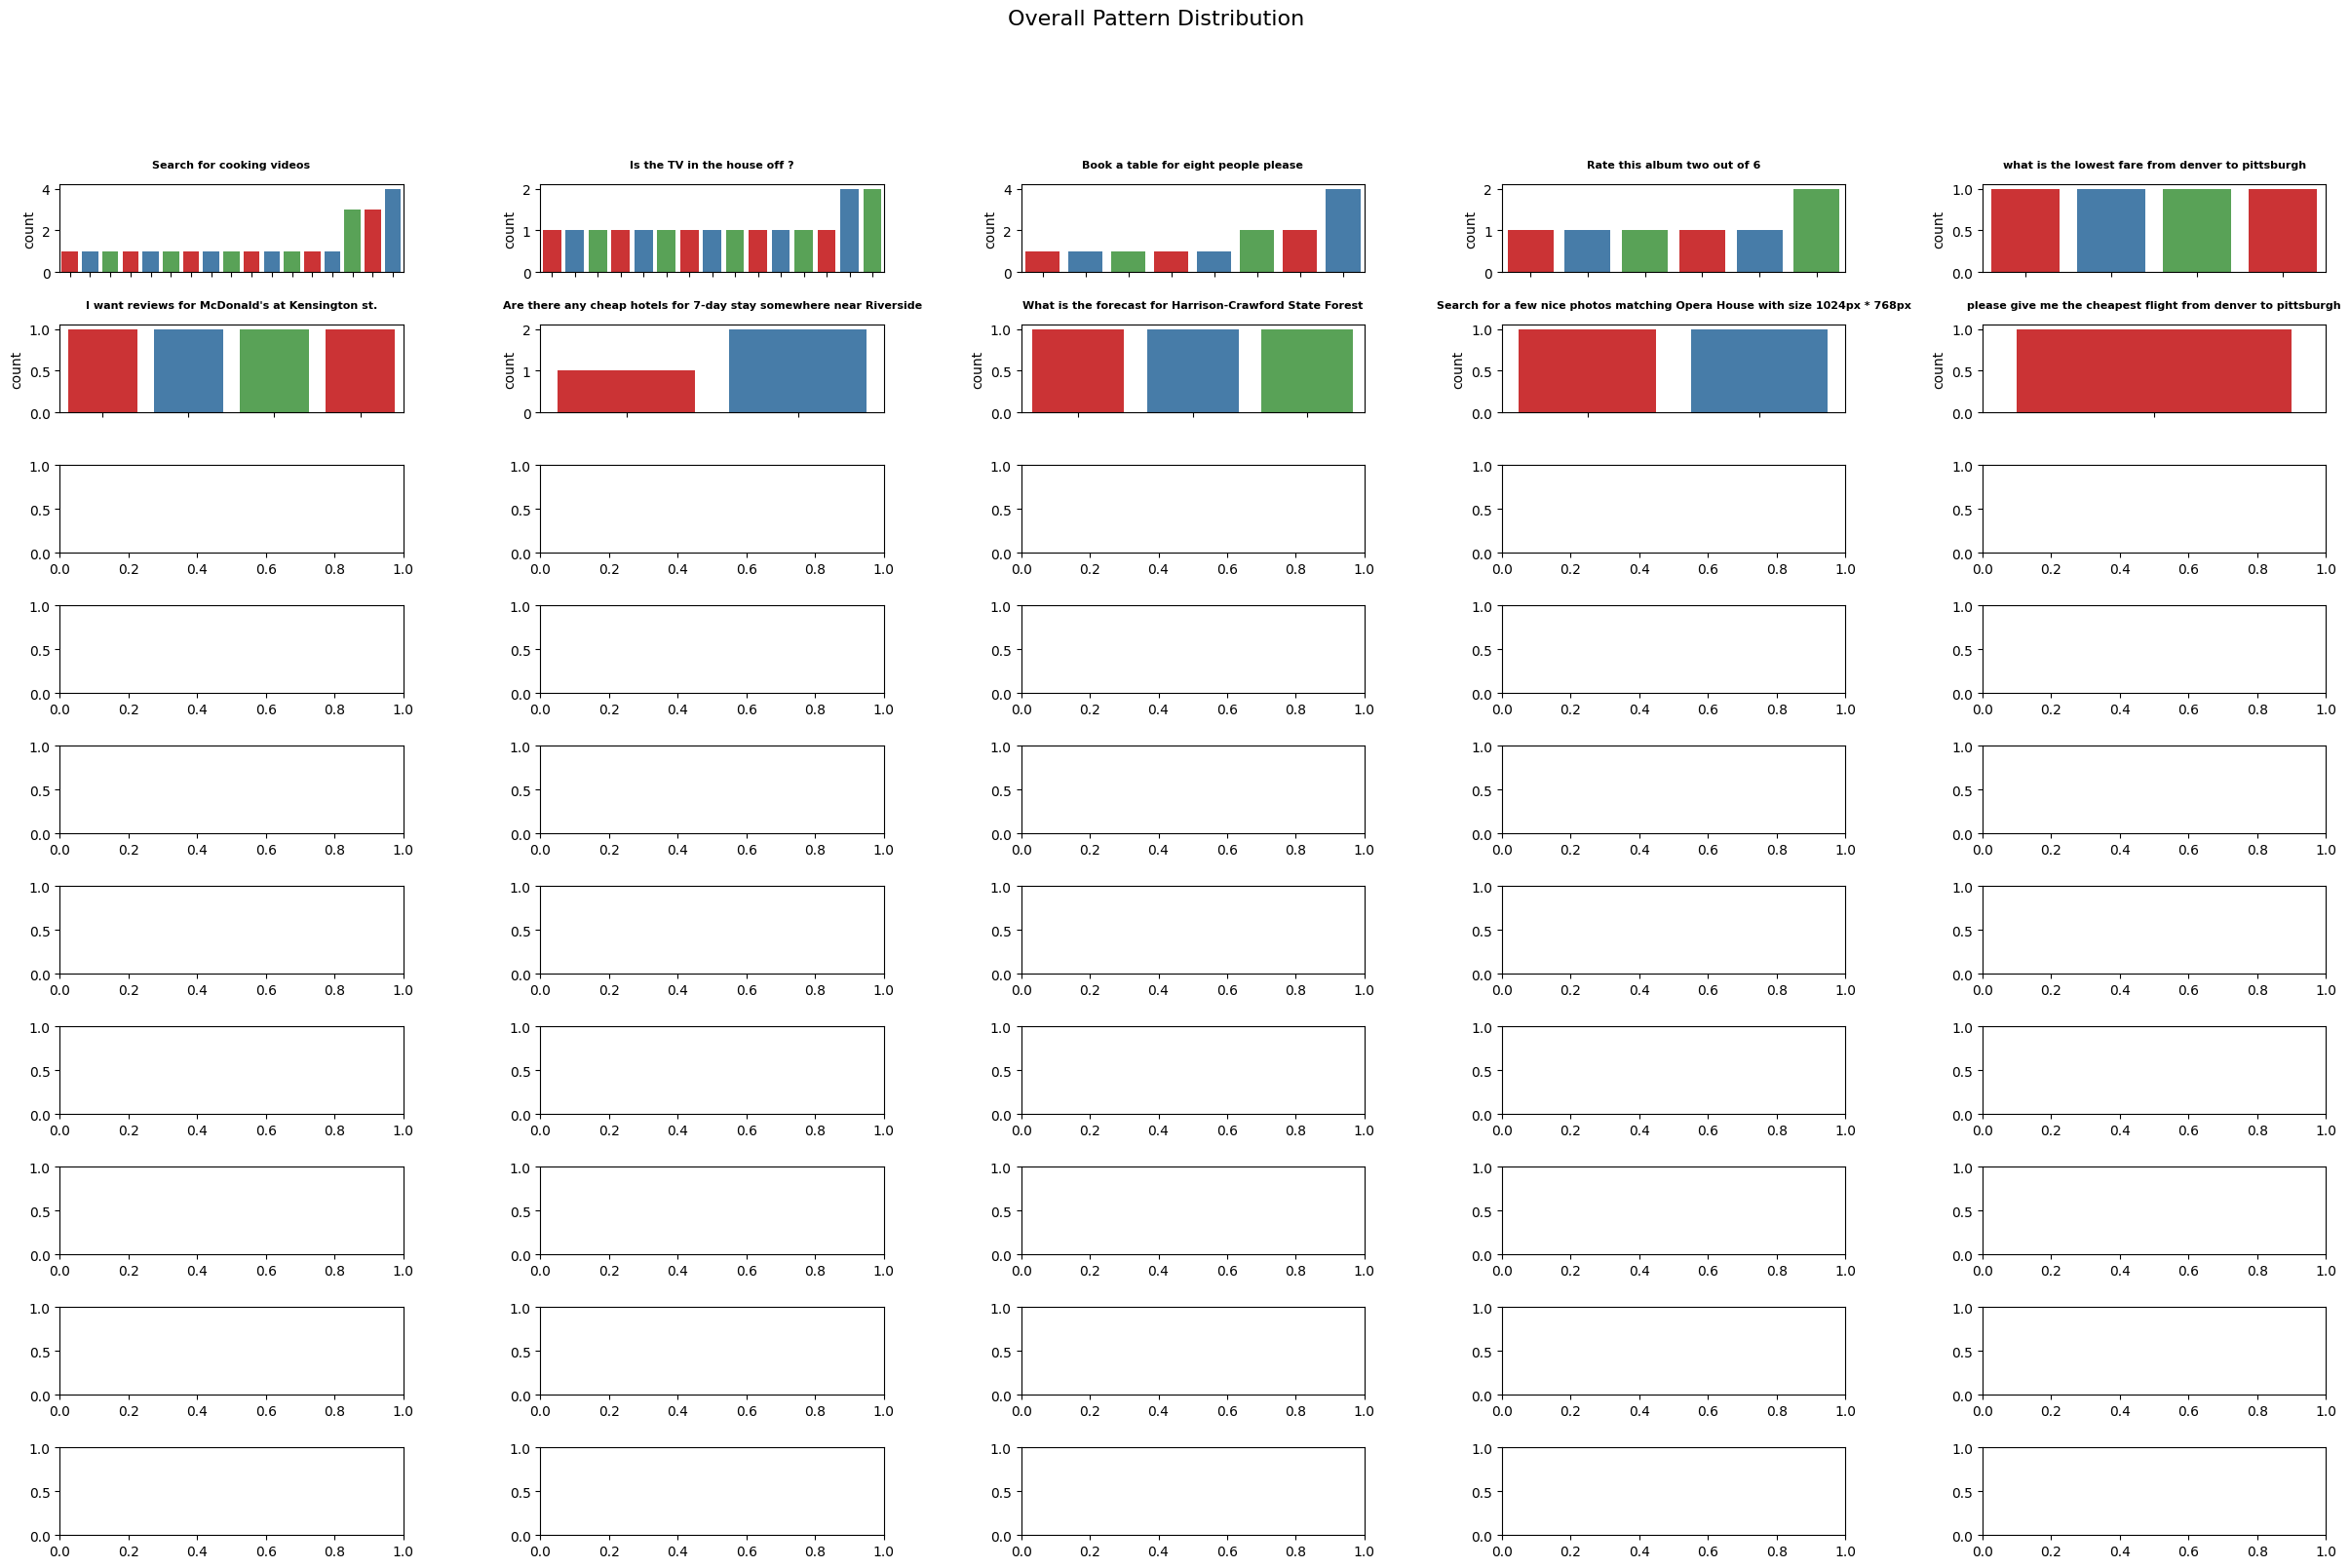

In [33]:
output_path = f"{os.getcwd()}/plots/Jorge-bootstrap-pattern-distribution-random.pdf"
plot_and_save_pattern_distribution(filtered_df, output_path, width=30, height=18, min_ncols=5)

### TED mean and median

In [38]:
print("TED mean and median for all paraphrases:")
ted_median = df["ted"].median()
ted_mean = df["ted"].mean()
print(f"   p1_ted: Median: {ted_median:.4f}. Mean: {ted_mean:.4f}.\n")

print("TED mean and median for correct paraphrases only:")
ted_median = filtered_df["ted"].median()
ted_mean = filtered_df["ted"].mean()
print(f"   p1_ted: Median: {ted_median:.4f}. Mean: {ted_mean:.4f}.\n")

TED mean and median for all paraphrases:
   p1_ted: Median: 4.0000. Mean: 4.0327.

TED mean and median for correct paraphrases only:
   p1_ted: Median: 4.0000. Mean: 3.6696.



## BERTscore mean and median

In [39]:
print("BERT scores mean and median for all paraphrases:")
bert_median = df["bert_score"].median()
bert_mean = df["bert_score"].mean()
print(f"   BERT scores: Median: {bert_median:.4f}. Mean: {bert_mean:.4f}.\n")

print("BERT scores mean and median for correct paraphrases only:")
bert_median = filtered_df["bert_score"].median()
bert_mean = filtered_df["bert_score"].mean()
print(f"   BERT scores: Median: {bert_median:.4f}. Mean: {bert_mean:.4f}.\n")

BERT scores mean and median for all paraphrases:
   BERT scores: Median: 0.5630. Mean: 0.5355.

BERT scores mean and median for correct paraphrases only:
   BERT scores: Median: 0.6271. Mean: 0.6356.



In [40]:
df[df['bert_score']<0.5]#rows that are semantically unrelated

,seed_id,intent,input_utterance,paraphrase_value,parameters,is_correct,source,bert_score,utterance_template,paraphrase_template,ted,duplicate,semantics
0,1,EndEC2Instance,Terminate i-a541 now,Finish i-a541 now.,"[['VM', 'i-a541']]",1,ParaQuality,0.399534,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ( . ) ),1.0,False,False
1,1,EndEC2Instance,Terminate i-a541 now,Complete i-a541 now.,"[['VM', 'i-a541']]",1,ParaQuality,0.387085,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( FRAG ( NP ( JJ ) ( NN ) ) ( ADVP ( RB ) ) ( ...,6.0,False,False
2,1,EndEC2Instance,Terminate i-a541 now,End i-a541 now.,"[['VM', 'i-a541']]",1,ParaQuality,0.398089,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( NN ) ( NP ) ( ADVP ) ) ( . ) ),2.0,False,False
3,1,EndEC2Instance,Terminate i-a541 now,Finish i-a541 now.,"[['VM', 'i-a541']]",1,ParaQuality,0.399534,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ( . ) ),1.0,False,False
4,1,EndEC2Instance,Terminate i-a541 now,Quit i-a541 right away.,"[['VM', 'i-a541']]",1,ParaQuality,0.302160,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ( . ) ),1.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,51,abbreviation,what does dfw mean,Dfw what is meaning?,"[['airport_code', 'dfw']]",0,ATIS,0.344279,( SBARQ ( WHNP ( WP ) ) ( SQ ( VBZ ) ( NP ) ( ...,( FRAG ( NP ( NNP ) ) ( WHNP ( WP ) ) ( SQ ( V...,6.0,False,False
1220,51,abbreviation,what does dfw mean,What is dfw shortcut meaning?,"[['airport_code', 'dfw']]",1,ATIS,0.459489,( SBARQ ( WHNP ( WP ) ) ( SQ ( VBZ ) ( NP ) ( ...,( SBARQ ( WHNP ( WP ) ) ( SQ ( VBZ ) ( NP ) ( ...,1.0,False,False
1221,51,abbreviation,what does dfw mean,dfw it's meaning International Airport Dallas ...,"[['airport_code', 'dfw']]",0,ATIS,0.003619,( SBARQ ( WHNP ( WP ) ) ( SQ ( VBZ ) ( NP ) ( ...,( S ( ADVP ( UH ) ) ( NP ( PRP ) ) ( VP ( VBZ ...,7.0,False,False
1222,51,abbreviation,what does dfw mean,dfw it's meaning Hotel,"[['airport_code', 'dfw']]",0,ATIS,0.078054,( SBARQ ( WHNP ( WP ) ) ( SQ ( VBZ ) ( NP ) ( ...,( S ( ADVP ( UH ) ) ( NP ( PRP ) ) ( VP ( VBZ ...,7.0,False,False


##### <div style="background-color: lightblue; padding: 10px; display: inline-block;">Statistical overview of duplicates.</div>

In [41]:
p_candidates = filtered_df.paraphrase_value.to_list()
unique_p_candidates = set(p_candidates)
num_duplicates = len(p_candidates) - len(unique_p_candidates)

print(
    "Count of recurring paraphrases, i.e., instances where paraphrases were repeatedly generated by the crowd worker, resulting in duplicates"\
    f" among the paraphrase set. For a list of {len(p_candidates)} correct paraphrases collected {num_duplicates} are duplicates."
    ""
)

Count of recurring paraphrases, i.e., instances where paraphrases were repeatedly generated by the crowd worker, resulting in duplicates among the paraphrase set. For a list of 790 correct paraphrases collected 19 are duplicates.


##### <div style="background-color: lightblue; padding: 10px; display: inline-block;">Statistical overview per seed utterance.</div>
Count the number of duplicates paraphrases for each seed utterance.

In [42]:
duplicates_data = []

for utr in filtered_df["input_utterance"].unique():
    df_row = filtered_df[filtered_df["input_utterance"] == utr]
    p_candidates = df_row.paraphrase_value.to_list()
    unique_p_candidates = set(p_candidates)
    num_duplicates = len(p_candidates) - len(unique_p_candidates)
    duplicates_data.append({"input_utterance": utr, "num_duplicates": num_duplicates})

duplicates_data.append({"input_utterance": "Total number of duplicates in bootstrap", "num_duplicates": sum(d["num_duplicates"] for d in duplicates_data)})
duplicates_df = pd.DataFrame(duplicates_data)

output_file = f"{os.getcwd()}/output/Jorge_bootstrap_crowd_duplicates_generation_stats.csv"
duplicates_df.to_csv(output_file, index=False)

duplicates_df

,input_utterance,num_duplicates
0,Find most popular photos tagged #LOVE,0
1,Search for a few nice photos matching Opera Ho...,0
2,Are the burglar alarms in the office malfuncti...,1
3,Is the TV in the house off ?,0
4,Any suggestions for an inexpensive hotel near ...,0
5,Are there any cheap hotels for 7-day stay some...,0
6,Send an email to Phil telling her that ''I got...,0
7,Give me 5 conference articles about text mining,1
8,I am looking for the latest scientific article...,0
9,Create a comment saying ''Best Voice Ever'',0


##### <div style="background-color: lightblue; padding: 10px; display: inline-block;">Repetead statistical overview per syntax template.</div>
Count the number of duplicates syntax templates among paraphrases for each seed utterance.

In [43]:
duplicates_data = []

for utr in filtered_df["input_utterance"].unique():
    df_row = filtered_df[filtered_df["input_utterance"] == utr]
    p_candidates = df_row.paraphrase_template.to_list()
    unique_p_candidates = set(p_candidates)
    num_duplicates = len(p_candidates) - len(unique_p_candidates)
    duplicates_data.append({"input_utterance": utr, "num_duplicates": num_duplicates})

duplicates_data.append({"input_utterance": "Total number of duplicates in bootstrap", "num_duplicates": sum(d["num_duplicates"] for d in duplicates_data)})
duplicates_df = pd.DataFrame(duplicates_data)

output_file = f"{os.getcwd()}/output/Jorge_bootstrap_crowd_duplicates_paraphrase_syntax_template_stats.csv"
duplicates_df.to_csv(output_file, index=False)

duplicates_df

,input_utterance,num_duplicates
0,Find most popular photos tagged #LOVE,10
1,Search for a few nice photos matching Opera Ho...,8
2,Are the burglar alarms in the office malfuncti...,2
3,Is the TV in the house off ?,0
4,Any suggestions for an inexpensive hotel near ...,1
5,Are there any cheap hotels for 7-day stay some...,6
6,Send an email to Phil telling her that ''I got...,2
7,Give me 5 conference articles about text mining,6
8,I am looking for the latest scientific article...,5
9,Create a comment saying ''Best Voice Ever'',1


## BERTscore distribution

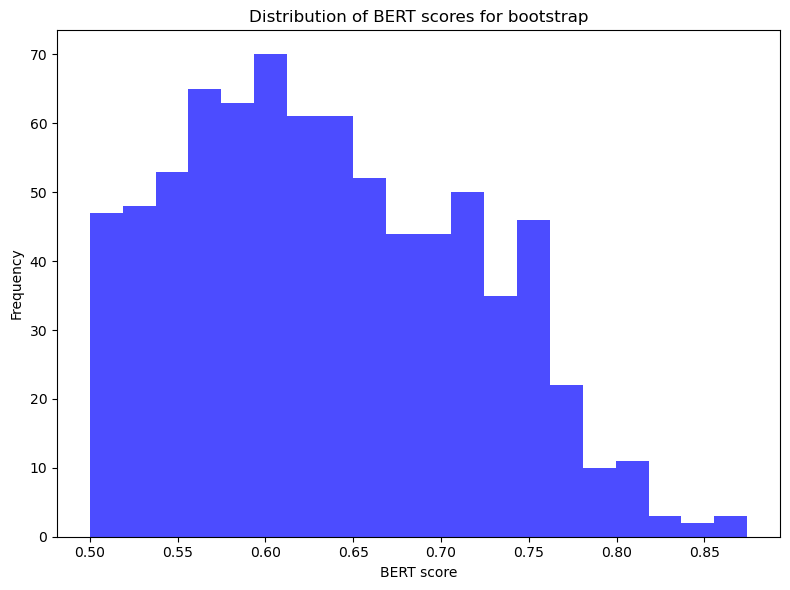

In [57]:
# Create a figure with subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of BERT scores for p1
ax.hist(filtered_df['bert_score'], bins=20, color='blue', alpha=0.7)
ax.set_title('Distribution of BERT scores for bootstrap')
ax.set_xlabel('BERT score')
ax.set_ylabel('Frequency')

plt.tight_layout()

# Save the plot to a file (e.g., a PDF file)
path_to_plot_file = f"{os.getcwd()}/plots/Jorge-bootstrap_correct_only_all_paraphrases-BERTscores-distribution.pdf"
plt.savefig(path_to_plot_file)

plt.show()


## TED score distribution

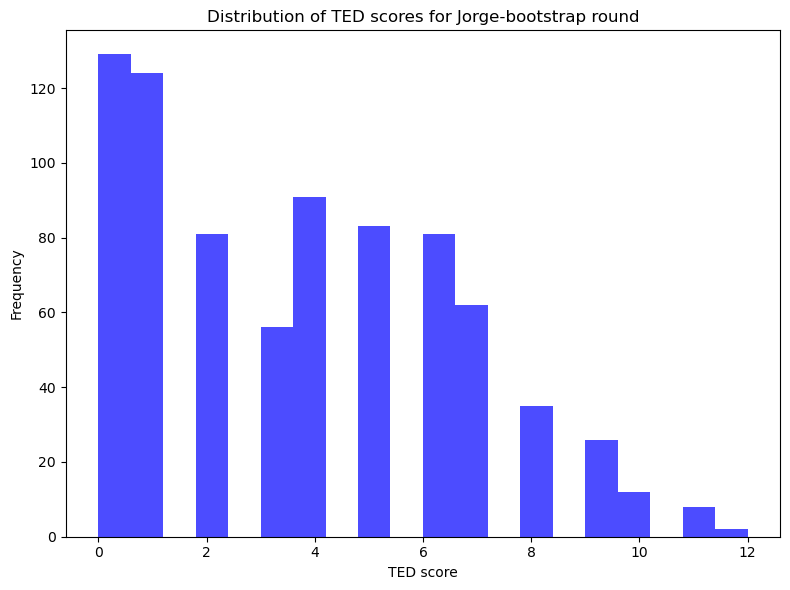

In [56]:
# Create a figure with subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of BERT scores for p1
ax.hist(filtered_df['ted'], bins=20, color='blue', alpha=0.7)
ax.set_title('Distribution of TED scores for Jorge-bootstrap round')
ax.set_xlabel('TED score')
ax.set_ylabel('Frequency')

plt.tight_layout()

# Save the plot to a file (e.g., a PDF file)
path_to_plot_file = f"{os.getcwd()}/plots/Jorge-bootstrap_correct_only_all_paraphrases-TEDscores-distribution.pdf"
plt.savefig(path_to_plot_file)

plt.show()


In [54]:
print(f"BERT Mean: {filtered_df['bert_score'].mean()}")
print(f"BERT Median: {filtered_df['bert_score'].median()}")
print(f"BERT standard deviation: {filtered_df['bert_score'].std()}")

print(f"TED Mean: {filtered_df['ted'].mean()}")
print(f"TED Median: {filtered_df['ted'].median()}")
print(f"TED standard deviation: {filtered_df['ted'].std()}")

BERT Mean: 0.6356243452025316
BERT Median: 0.62709697
BERT standard deviation: 0.08107737910818448
TED Mean: 3.669620253164557
TED Median: 4.0
TED standard deviation: 2.8924031623078026


### **Metrics scores**

In [50]:
def compute_metrics_condition_all(df,condition):

    ttrs = []
    mean_pincs = []
    iu_dataset = {}

    for iu in tqdm(df["input_utterance"].unique(), position=0, leave=True, desc = f"Handled input utterance for {condition}"):
        ttr, mean_pinc,_ = compute_metrics(df, iu)
        ttrs.append(ttr)
        mean_pincs.append(mean_pinc)
        iu_dataset[iu] = df[df["input_utterance"] == iu]["paraphrase_value"].values
    

    ttrs = np.array(ttrs)
    mean_pincs = np.array(mean_pincs)
    with tqdm(total=3, position=0, leave=True, desc="Calculating metrics") as pbar:
        div_score = metrics.compute_div(iu_dataset)
        pbar.update(1)
        
        bleu_score = metrics.compute_corpus_bleu(iu_dataset)
        pbar.update(1)
        
        gleu_score = metrics.compute_corpus_gleu(iu_dataset)
        pbar.update(1)
    
    return {"condition": condition, "mean_ttr": ttrs.mean(), "mean_pinc": mean_pincs.mean(), "div": div_score, 
            "bleu": bleu_score, "gleu": gleu_score, "bertscore": df.bert_score.mean()}

In [51]:
metrics_summary = compute_metrics_condition_all(filtered_df, "Jorge-bootstrap")
metrics_summary

Calculating metrics: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


{'condition': 'Jorge-bootstrap',
 'mean_ttr': 0.19677162428640926,
 'mean_pinc': 0.21544510709444217,
 'div': 0.5982934363686935,
 'bleu': 0.011046737290586585,
 'gleu': 0.015538691408708822,
 'bertscore': 0.6356243452025316}

### Count how many time TED = 0

In [45]:
TED_value = 0
count = filtered_df['ted'].value_counts()[TED_value]
print(f"TED = {TED_value} occured {count}")

TED_value = 1
count = filtered_df['ted'].value_counts()[TED_value]
print(f"TED = {TED_value} occured {count}")

TED_value = 2
count = filtered_df['ted'].value_counts()[TED_value]
print(f"TED = {TED_value} occured {count}")

TED_value = 3
count = filtered_df['ted'].value_counts()[TED_value]
print(f"TED = {TED_value} occured {count}")

TED = 0 occured 129
TED = 1 occured 124
TED = 2 occured 81
TED = 3 occured 56
